In [2]:
import  tensorflow  as tf
import matplotlib.pyplot as plt
import csv
import numpy as np
import os
import string
import requests
import io
import nltk
from zipfile import ZipFile
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.python.framework import ops


import sys
reload(sys)
sys.setdefaultencoding('utf-8')

ops.reset_default_graph()

In [3]:
sess = tf.Session()

In [4]:
batch_size = 200
max_features = 1000

In [5]:
save_file_name = 'temp_spam_data.csv'
if os.path.isfile(save_file_name):
    text_data = []
    with open(save_file_name, 'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        for row in reader:
            text_data.append(row)
            
else:
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    
    text_data = file.decode()
    text_data = text_data.encode('ascii', errors ='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x) >= 1]

    with open(save_file_name, 'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)

In [6]:
texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]


target = [1. if x =='spam' else 0. for x in target]

texts = [x.lower() for x in texts]

texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]
texts = [' '.join(x.split()) for x in texts]

In [7]:
def tokenizer(text):
    words = nltk.word_tokenize(text)
    return words

# Create TF-IDF of texts
tfidf = TfidfVectorizer(tokenizer=tokenizer, stop_words='english', max_features=max_features)
sparse_tfidf_texts = tfidf.fit_transform(texts)

LookupError: 
**********************************************************************
  Resource u'tokenizers/punkt/english.pickle' not found.  Please
  use the NLTK Downloader to obtain the resource:  >>>
  nltk.download()
  Searched in:
    - '/Users/lipingzhang/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - u''
**********************************************************************

In [8]:
train_indices = np.random.choice(sparse_tfidf_texts.shape[0], round(0.8 * sparse_tfidf_texts.shape[0]), replace=False)

test_indices = np.array(list(set(range(sparse_tfidf_texts.shape[0])) -set(train_indices)))
texts_train = sparse_tfidf_texts[train_indices]
texts_test = sparse_tfidf_texts[test_indices]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])

NameError: name 'sparse_tfidf_texts' is not defined

In [9]:
A = tf.Variable(tf.random_normal(shape=[max_features, 1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

x_data = tf.placeholder(shape=[None, max_features], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

model_output = tf.add(tf.matmul(x_data, A), b)

In [10]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

prediction = tf.round(tf.sigmoid(model_output))
prediction_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(prediction_correct)

In [11]:
my_opt = tf.train.GradientDescentOptimizer(0.0025)
train_step = my_opt.minimize(loss)

init = tf.global_variables_initializer()
sess.run(init)

In [12]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []
for i in range(10000):
    rand_index = np.random.choice(texts_train.shape[0], size=batch_size)
    rand_x = texts_train[rand_index].todense()
    rand_y = np.transpose([target_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    
    if (i + 1) % 100 == 0:
        i_data.append(i + 1)
        train_loss_temp = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
        train_loss.append(train_loss_temp)
        
        test_loss_temp = sess.run(loss, feed_dict={x_data: texts_test.todense(), y_target:np.transpose([target_test])})
        test_loss.append(test_loss_temp)
        
        train_acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x, y_target: rand_y})
        train_acc.append(train_acc_temp)
        
        test_acc_temp = sess.run(accuracy, feed_dict={x_data: texts_test.todense(), y_target: np.transpose([target_test])})
        test_acc.append(test_acc_temp)
        
    if (i + 1) % 500 == 0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, train_acc_temp]
        acc_and_loss = [np.round(x, 2) for x in acc_and_loss]
        print('Generation # {}.Train Loss (Test Loss): {:.2f} ({:.2f}).Train Acc(Test Acc): {:.2f})'.format(*acc_and_loss))

NameError: name 'texts_train' is not defined

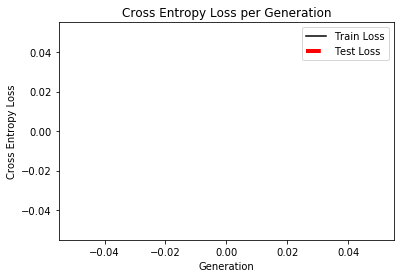

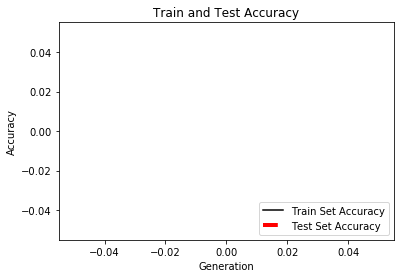

In [19]:
# Plot loss over time# Plot l 
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

# Plot train and test acccuracy
plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()